#Ujian Tengah Semester Data Engineering

---


Nama : Riza Setiawan Soetedjo

NIM : 195150207111062

Kelas : DE-B

#Retrieve Data Menggunakan API

API yang digunakan adalah API yang menyimpan data berupa karakter, lokasi, dan episode dari serial TV Rick And Morty. Pertama-tama mengambil data json dari tiap-tiap API. Baris pertama mengambil data karakter, baris kedua mengambil data lokasi, dan baris ketiga mengambil data episode.

Sayangnya, API ini membatasi sehingga **hanya 20 data saja yang bisa diakses dalam 1 page**.

In [1]:
#API membatasi 20 data per page
!wget https://rickandmortyapi.com/api/character
!wget https://rickandmortyapi.com/api/location
!wget https://rickandmortyapi.com/api/episode

--2021-10-29 14:33:59--  https://rickandmortyapi.com/api/character
Resolving rickandmortyapi.com (rickandmortyapi.com)... 157.245.84.7, 68.183.27.198
Connecting to rickandmortyapi.com (rickandmortyapi.com)|157.245.84.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17412 (17K) [application/json]
Saving to: ‘character’

character           100%[===================>]  17.00K  --.-KB/s    in 0.1s    

2021-10-29 14:34:00 (168 KB/s) - ‘character’ saved [17412/17412]

--2021-10-29 14:34:00--  https://rickandmortyapi.com/api/location
Resolving rickandmortyapi.com (rickandmortyapi.com)... 157.245.84.7, 68.183.27.198
Connecting to rickandmortyapi.com (rickandmortyapi.com)|157.245.84.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22310 (22K) [application/json]
Saving to: ‘location’

location            100%[===================>]  21.79K  --.-KB/s    in 0.02s   

2021-10-29 14:34:00 (1.17 MB/s) - ‘location’ saved [22310/22310]

--2021-10-29

Sebelum itu, kita mengimport semua library yang akan kita gunakan nantinya selama proses berlangsung.

In [2]:
#Import library
import os
import pandas as pd
import numpy as np
import urllib.request
import json
from datetime import datetime
import sqlite3

Untuk memudahkan logging nantinya, fungsi log ini akan dibuat sehingga mengurangi baris kode selama proses nantinya jika ingin melakukan logging. Loggingnya akan dibuat dalam format `[Tanggal] Deskripsi aktivitas`

In [3]:
#Fungsi untuk Logging
def log(msg):
  timestamp_format = '%d-%h-%Y %H:%M:%S'
  timestamp = datetime.now().strftime(timestamp_format)
  with open('logfile.txt','a') as f:
    f.write(f'[{timestamp}] {msg}\n'.format(timestamp, msg))

#Extract Data

Fungsi ini merupakan fungsi untuk melakukan extract dari file yang telah didownload dari API. Seperti yang disebutkan sebelumnya, file yang didownload dari API hanya akan memberikan 20 data, tetapi pada file tersebut terdapat juga url untuk ke page selanjutnya, dan banyak page untuk semua data.

Pertama, info banyak page dan urlnya akan diambil dari file yang telah didownload. Kemudian melakukan looping untuk mengambil data dari tiap page. Data tiap page tersebut akan disimpan dalam array bernama `total_data`.

Setelah itu, membuat file json baru dengan `total_data` sebagai isinya dan mengembalikan `total_data` setelah diubah menjadi DataFrame.

In [4]:
def extract(json_temp, filename):
  log(f"Extract dari file {filename[:-5]} dan membuat file {filename}")
  n_pages = json_temp['info']['pages']
  url = json_temp['info']['next'][:-1]
  total_data = []
  for i in range(1,n_pages+1):
    link = url+str(i)
    data = json.loads(urllib.request.urlopen(link).read())
    total_data += data['results']
  with open(filename,'a') as f:
    f.write(json.dumps(total_data))
  os.remove(filename[:-5])
  return (pd.DataFrame(total_data))

Fungsi extract dijalankan untuk tiap file. Setiap DataFrame yang dikembalikan akan disimpan dalam variabel. DataFrame - DataFrame inilah yang akan digunakan untuk proses Tranformasi hingga Load.

In [5]:
log('Fase Extract dimulai')

json_chara = json.load(open('character'))
df_chara = extract(json_chara, 'character.json')

json_location = json.load(open('location'))
df_location = extract(json_location, 'location.json')

json_eps = json.load(open('episode'))
df_eps = extract(json_eps, 'episode.json')

log('Fase Extract selesai')

#Transform Data

## Schema Data

Berikut data dictionary atau schema dari tiap data yang diambil dari API

###Character

| No. | Nama Atribut | Tipe Data   | Deskripsi Data                                                                   | Contoh Data                                                                                 |
|-----|--------------|-------------|----------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------|
| 1.  | id           | int         | Id tiap character                                                                | 1                                                                                           |
| 2.  | name         | string      | Nama tiap character                                                              | Rick Sanchez                                                                                |
| 3.  | status       | string      | Status tiap character antara <br>"Alive", "Dead", atau "Unknown"                 | Alive                                                                                       |
| 4.  | species      | string      | Spesies character                                                                | Human                                                                                       |
| 5.  | type         | string      | Tipe atau subspesies character                                                   | Parasite                                                                                    |
| 6.  | gender       | string      | Jenis kelamin character antara "Female", <br>"Male", "Genderless", dan "Unknown" | Male                                                                                        |
| 7.  | origin       | object      | Nama dan link dari lokasi asal character                                         | {'name' :'Earth (C-137)', 'url':'https://rickandmortyapi.com/api/location/1 '}              |
| 8.  | location     | object      | Nama dan link dari lokasi terakhir character                                     | {'name' :'Earth (C-137)', 'url':'https://rickandmortyapi.com/api/location/1 '}              |
| 9.  | image        | string(url) | Tautan ke gambar 300x300px character                                             | https://rickandmortyapi.com/api/character/avatar/1.jpeg                                     |
| 10. | episode      | array(urls) | Daftar episode dimana character muncul                                           | ['https://rickandmortyapi.com/api/episode/1 ','https://rickandmortyapi.com/api/episode/2 '] |
| 11. | url          | string(url) | Tautan ke data character                                                         | https://rickandmortyapi.com/api/character/1                                                 |
| 12. | created      | string      | Waktu saat character ditambahkan ke database                                     | 2017-11-04T18:48:46.250Z                                                                    |

###Location

| No. | Nama Atribut | Tipe Data   | Deskripsi Data                                                      | Contoh Data                                                                                        |
|-----|--------------|-------------|---------------------------------------------------------------------|----------------------------------------------------------------------------------------------------|
| 1.  | id           | int         | Id tiap location                                                    | 1                                                                                                  |
| 2.  | name         | string      | Nama tiap location                                                  | Earth (C-137)                                                                                      |
| 3.  | type         | string      | Tipe tiap location                                                  | Planet                                                                                             |
| 4.  | dimension    | string      | Dimensi tempat location berada                                      | Dimension C-137                                                                                    |
| 5.  | residents    | array(urls) | Daftar tautan data character yang terakhir <br>terlihat di location | ['https://rickandmortyapi.com/api/character/38 ', 'https://rickandmortyapi.com/api/character/45 '] |
| 6.  | url          | string(url) | Tautan ke data location                                             | https://rickandmortyapi.com/api/location/1                                                         |
| 7.  | created      | string      | Waktu saat location ditambahkan ke database                         | 2017-11-04T18:48:46.250Z                                                                           |

###Episode

| No. | Nama Atribut | Tipe Data   | Deskripsi Data                                        | Contoh Data                                                                                        |
|-----|--------------|-------------|-------------------------------------------------------|----------------------------------------------------------------------------------------------------|
| 1.  | id           | int         | Id tiap episode                                       | 1                                                                                                  |
| 2.  | name         | string      | Nama tiap episode                                     | Pilot                                                                                              |
| 3.  | air_date     | string      | Tanggal siar episode                                  | December 2, 2013                                                                                   |
| 4.  | episode      | string      | Kode tiap episode                                     | S01E01                                                                                             |
| 5.  | characters   | array(urls) | Daftar tautan data character yang ada pada<br>episode | ['https://rickandmortyapi.com/api/character/38 ', 'https://rickandmortyapi.com/api/character/45 '] |
| 6.  | url          | string(url) | Tautan ke data episode                                | https://rickandmortyapi.com/api/episode/1                                                          |
| 7.  | created      | string      | Waktu saat episode ditambahkan ke database            | 2017-11-04T18:48:46.250Z                                                                           |

###Rencana Database

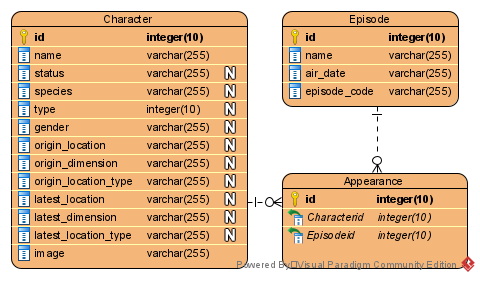

##Proses Transform

### Hapus Kolom

Tahap pertama pada Transform adalah menghapus kolom yang tidak relevan pada DataFrame.

Kolom url yang menyimpan tautan ke tiap data dan kolom created yang menyimpan waktu kapan data masuk ke database tidaklah terlalu relevan sebagai data. 

Pertama, kolom url menyimpan data yang telah kita masukkan di DataFrame sehingga tidak akan digunakan sama sekali. Kedua, kolom created menyimpan waktu yang masuk ke database dan bukanlah seperti waktu kapan karakter tersebut muncul sehingga tidaklah terlalu relevan untuk digunakan.

Terakhir kita mengecek info DataFrame untuk melihat apakah kolom tersebut telah terhapus atau tidak

In [6]:
log("Fase Transform dimulai")
#Hapus kolom tidak relevan (url, created) pada Character, Location, dan Episode
def hapusKolom(columns,df, nama_df):
  for column in columns:
    if column in df.columns:
      log(f'Hapus kolom {column} dari DataFrame {nama_df}')
      df = df.drop(columns=[column])
  return df

df_chara = hapusKolom(['url','created'], df_chara, "Character")
df_location = hapusKolom(['url','created'], df_location, "Location")
df_eps = hapusKolom(['url','created'], df_eps, "Episode")

In [7]:
df_chara.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        671 non-null    int64 
 1   name      671 non-null    object
 2   status    671 non-null    object
 3   species   671 non-null    object
 4   type      671 non-null    object
 5   gender    671 non-null    object
 6   origin    671 non-null    object
 7   location  671 non-null    object
 8   image     671 non-null    object
 9   episode   671 non-null    object
dtypes: int64(1), object(9)
memory usage: 52.5+ KB


In [8]:
df_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         108 non-null    int64 
 1   name       108 non-null    object
 2   type       108 non-null    object
 3   dimension  108 non-null    object
 4   residents  108 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.3+ KB


In [9]:
df_eps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          41 non-null     int64 
 1   name        41 non-null     object
 2   air_date    41 non-null     object
 3   episode     41 non-null     object
 4   characters  41 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.7+ KB


### Mengganti nilai kosong dengan nilai null

Jika melihat pada info sebelumnya, tidak ada data null yang terdeteksi padahal ada beberapa bagian yang nilainya kosong atau hanya berisi `''`. Hal ini dikarenakan DataFrame tidak mengganggap nilai kosong tersebut sebagai null. Oleh karena itu, kita menyamakan semua nilai kosong menjadi np.nan sehingga dapat terdeteksi oleh DataFrame.

Hasil akhir dapat dilihat kalau ada nilai null pada DataFrame `character` pada kolom `type`

In [10]:
#Isi nilai kosong dengan null
def isiNull(df, nama_df, value):
  log(f"Mengganti nilai {(value if value!='' else 'kosong')} menjadi np.nan pada DataFrame {nama_df}")

  regex = r'^\s*$' if value=='' else fr'(?i)^{value}$'
  df = df.replace(regex, np.nan, regex=True)
  return df

df_chara = isiNull(df_chara, "Character", '')
df_location = isiNull(df_location, "Location", '')
df_eps = isiNull(df_eps, "Episode", '')

In [11]:
df_chara.isnull().sum()

id            0
name          0
status        0
species       0
type        347
gender        0
origin        0
location      0
image         0
episode       0
dtype: int64

In [12]:
df_location.isnull().sum()

id           0
name         0
type         0
dimension    0
residents    0
dtype: int64

In [13]:
df_eps.isnull().sum()

id            0
name          0
air_date      0
episode       0
characters    0
dtype: int64

### Mengubah nama kolom

Pada DataFrame, ada kolom yang namanya kurang tepat merepresentasikan data tersebut. Seperti pada `character`, kolom origin dan location sama-sama merepresentasikan lokasi karakter tetapi bedanya origin merepresentasikan lokasi asal dan location merepresentasikan lokasi terakhir.

Oleh karena itu, pada DataFrame `character`, kolom `origin` akan diubah menjadi `origin_location` dan `location` menjadi `latest_location`

Selain itu, pada DataFrame `episode`, kolom `episode` akan diubah menjadi `episode_code`

Kode-kode selanjutnya digunakan untuk mengecek apakah perubahan yang dilakukan berhasil atau tidak.

In [14]:
#Ubah nama kolom origin jadi kolom origin_location, location jadi kolom latest_location, dan episode jadi episode_code
def renameColumns(dict_column, df, nama_df):
  kolomLama = ', '.join(dict_column.keys())
  kolomBaru = ', '.join(dict_column.values())
  log(f'Mengganti kolom [{kolomLama}] menjadi kolom [{kolomBaru}] pada DataFrame {nama_df}')
  df = df.rename(columns = dict_column)
  return df

df_chara = renameColumns({'origin':'origin_location','location':'latest_location'}, df_chara, "Character")
df_eps = renameColumns({'episode':'episode_code'}, df_eps, "Episode")

In [15]:
df_chara.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               671 non-null    int64 
 1   name             671 non-null    object
 2   status           671 non-null    object
 3   species          671 non-null    object
 4   type             324 non-null    object
 5   gender           671 non-null    object
 6   origin_location  671 non-null    object
 7   latest_location  671 non-null    object
 8   image            671 non-null    object
 9   episode          671 non-null    object
dtypes: int64(1), object(9)
memory usage: 52.5+ KB


In [16]:
df_eps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            41 non-null     int64 
 1   name          41 non-null     object
 2   air_date      41 non-null     object
 3   episode_code  41 non-null     object
 4   characters    41 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.7+ KB


###Mengubah kolom bertipe data dict menjadi tipe data lain

Jika data ingin dibentuk dalam bentuk data terstruktur, kolom-kolom pada data tersebutnya sebaiknya tidak menyimpan nilai yang bersifat list atau array ataupun dictionary yang dapat menyimpan banyak nilai. 

Pada DataFrame `character`, `origin_location` dan `latest_location` menyimpan sebuah dictionary yang berupa nama lokasi dan url ke data lokasi tersebut. Oleh karena itu, nilai pada kolom tersebut akan diubah sehingga hanya menyimpan nama lokasi tersebut dan membuang urlnya.

Kode selanjutnya mengecek apakah perubahannya berhasil atau tidak.

In [17]:
#Ubah dict sehingga menjadi namanya saja
def ubahDict(columns,df,atributs):
  for i in range(len(columns)):
    log(f'Ubah dict pada kolom {columns[i]} sehingga menjadi {atributs[i]}nya saja')
    df[columns[i]] = df[columns[i]].apply(lambda x: x[atributs[i]])
  return df

df_chara = ubahDict(['origin_location','latest_location'],df_chara, ['name','name'])

In [18]:
df_chara.head()

,id,name,status,species,type,gender,origin_location,latest_location,image,episode
0,1,Rick Sanchez,Alive,Human,NaN,Male,Earth (C-137),Earth (Replacement Dimension),https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/1, ht..."
1,2,Morty Smith,Alive,Human,NaN,Male,Earth (C-137),Earth (Replacement Dimension),https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/1, ht..."
2,3,Summer Smith,Alive,Human,NaN,Female,Earth (Replacement Dimension),Earth (Replacement Dimension),https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht..."
3,4,Beth Smith,Alive,Human,NaN,Female,Earth (Replacement Dimension),Earth (Replacement Dimension),https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht..."
4,5,Jerry Smith,Alive,Human,NaN,Male,Earth (Replacement Dimension),Earth (Replacement Dimension),https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht..."


###Menambah kolom baru dengan nilai NaN

Sebelum proses Load, DataFrame `character` dan `location` akan digabung menjadi satu DataFrame. Oleh karena itu, data-data dari DataFrame `location` yang akan digabung pada DataFrame `character` harus disimpan dalam sebuah kolom baru pada DataFrame `character`.

Untuk memudahkan pemindahan data, dibuatlah kolom baru dengan nilai kosong yang akan diupdate pada saat penggabungan DataFramenya.

Kode selanjutnya mengecek apakah kolom tersebut berhasil ditambahkan atau tidak.

In [19]:
#Menambah kolom baru kepada df_chara dengan nilai NaN
def addColumn(pos, name, values, df, nama_df):
  kolom_baru = ', '.join(name)
  log(f'Menambah kolom {kolom_baru} pada DataFrame {nama_df}')
  for i in range(len(pos)):
    df.insert(pos[i], name[i], values[i])
  return df

df_chara = addColumn([7,8,10,11],
                     ['origin_dimension',
                      'origin_location_type',
                      'latest_dimension', 
                      'latest_location_type'], 
                     [[np.nan]*df_chara.shape[0] for i in range(4)],
                     df_chara, 'Character')

In [20]:
df_chara.head()

,id,name,status,species,type,gender,origin_location,origin_dimension,origin_location_type,latest_location,latest_dimension,latest_location_type,image,episode
0,1,Rick Sanchez,Alive,Human,NaN,Male,Earth (C-137),NaN,NaN,Earth (Replacement Dimension),NaN,NaN,https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/1, ht..."
1,2,Morty Smith,Alive,Human,NaN,Male,Earth (C-137),NaN,NaN,Earth (Replacement Dimension),NaN,NaN,https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/1, ht..."
2,3,Summer Smith,Alive,Human,NaN,Female,Earth (Replacement Dimension),NaN,NaN,Earth (Replacement Dimension),NaN,NaN,https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht..."
3,4,Beth Smith,Alive,Human,NaN,Female,Earth (Replacement Dimension),NaN,NaN,Earth (Replacement Dimension),NaN,NaN,https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht..."
4,5,Jerry Smith,Alive,Human,NaN,Male,Earth (Replacement Dimension),NaN,NaN,Earth (Replacement Dimension),NaN,NaN,https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht..."


###Menggabungkan DataFrame character dan DataFrame location

Data yang akan digabungkan pada DataFrame `character` dari DataFrame `location` adalah kolom `dimension` dan kolom `type`.

Penggabungannya akan berdasarkan 2 kolom yang menyimpan nama lokasi di DataFrame `character` yaitu `origin_location` dan `latest_location`. Setiap nilai pada kolom ini akan dicocokkan dengan kolom `name` pada DataFrame `location` untuk mengisi kolom `origin_dimension`, `origin_location_type`, `latest_dimension`, dan `latest_location_type`.

Sayangnya, ada beberapa data `location` yang tidak dapat digabungkan dikarenakan tidak ada karakter yang berasal dari lokasi tersebut ataupun terakhir berada di lokasi tersebut. Untuk data `location` yang hilang dapat dilihat pada kode kedua.

Kode ketiga akan mengecek apakah proses penggabungannya berhasil atau tidak.

In [21]:
#Mengubah nilai kolom origin_dimension, origin_location_type, latest_dimension, dan latest_location_type berdasarkan df_location
def combine(df1,df2,keyDf1,keyDf2, nama_df1, nama_df2, kolomDf1, kolomDf2):
  nama_kolom = ', '.join(kolomDf1)
  log(f"Mengubah nilai kolom [{nama_kolom}] pada DataFrame {nama_df1} berdasarkan DataFrame {nama_df2}")
  for i in range(len(df2[keyDf2])):
    for j in range(len(kolomDf1)):
      x = kolomDf1[j]
      y = kolomDf2[j]
      df1[x] = df1[x].mask(df1[keyDf1] == df2[keyDf2][i], df2[y][i])
  return df1

log("Menggabung DataFrame Character dan DataFrame Location")
df_chara = combine(df_chara,df_location, 'origin_location' ,'name', 'Character', 'Location',
        ['origin_dimension','origin_location_type'],['dimension','type'])
df_chara = combine(df_chara,df_location, 'latest_location' ,'name', 'Character', 'Location',
        ['latest_dimension','latest_location_type'],['dimension','type'])

In [22]:
#Data yang tidak tergabung
list_lokasi = set(np.concatenate((df_chara['origin_location'].to_numpy(), df_chara['latest_location'].to_numpy()), axis=None))
df_location[df_location['name'].isin(list_lokasi)==False]

,id,name,type,dimension,residents
66,67,Blips and Chitz,Arcade,Replacement Dimension,[]
68,69,Earth (C-35),Planet,Dimension C-35,[]
94,95,New Improved Galactic Federation Quarters,Space station,Replacement Dimension,[]


In [23]:
df_chara.head()

,id,name,status,species,type,gender,origin_location,origin_dimension,origin_location_type,latest_location,latest_dimension,latest_location_type,image,episode
0,1,Rick Sanchez,Alive,Human,NaN,Male,Earth (C-137),Dimension C-137,Planet,Earth (Replacement Dimension),Replacement Dimension,Planet,https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/1, ht..."
1,2,Morty Smith,Alive,Human,NaN,Male,Earth (C-137),Dimension C-137,Planet,Earth (Replacement Dimension),Replacement Dimension,Planet,https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/1, ht..."
2,3,Summer Smith,Alive,Human,NaN,Female,Earth (Replacement Dimension),Replacement Dimension,Planet,Earth (Replacement Dimension),Replacement Dimension,Planet,https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht..."
3,4,Beth Smith,Alive,Human,NaN,Female,Earth (Replacement Dimension),Replacement Dimension,Planet,Earth (Replacement Dimension),Replacement Dimension,Planet,https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht..."
4,5,Jerry Smith,Alive,Human,NaN,Male,Earth (Replacement Dimension),Replacement Dimension,Planet,Earth (Replacement Dimension),Replacement Dimension,Planet,https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht..."


###Mengubah format tanggal pada kolom air_date 

Jika melihat contoh pada schema Episode, air_date memiliki format `Bulan TGL, TAHUN`. Ada kemungkinan beberapa bahasa pemrograman tidak dapat mengubah data ini menjadi sebuah tanggal. Oleh karena itu, dilakukanlah perubahan format tanggal menjadi DD-Bul-YYYY.

Jadi, misalnya nilainya `December 13,2021` akan berubah menjadi `13-Dec-2021`

Kode selanjutnya digunakan untuk mengecek apakah perubahan tersebut berhasil atau tidak.

In [24]:
#Convert air_date pada Episode menjadi DD-Mon-YYYY
def convertDate(x):
  x = x.split()
  date = x[1][:-1] if (len(x[1][:-1]) > 1) else f"0{x[1][:-1]}"
  return "-".join([date, x[0][:3], x[2]])

log("Mengubah format air_date pada DataFrame Episode menjadi DD-Mon-YYYY")
df_eps['air_date'] = df_eps['air_date'].apply(convertDate)

In [25]:
df_eps.head()

,id,name,air_date,episode_code,characters
0,1,Pilot,02-Dec-2013,S01E01,"[https://rickandmortyapi.com/api/character/1, ..."
1,2,Lawnmower Dog,09-Dec-2013,S01E02,"[https://rickandmortyapi.com/api/character/1, ..."
2,3,Anatomy Park,16-Dec-2013,S01E03,"[https://rickandmortyapi.com/api/character/1, ..."
3,4,M. Night Shaym-Aliens!,13-Jan-2014,S01E04,"[https://rickandmortyapi.com/api/character/1, ..."
4,5,Meeseeks and Destroy,20-Jan-2014,S01E05,"[https://rickandmortyapi.com/api/character/1, ..."


###Membuat Fact table antara DataFrame Episode dan Character

Jika melihat DataFrame `episode` dan DataFrame `character`, ada satu lagi kolom yang menyimpan data bertipe list, yaitu kolom `characters` pada DataFrame `episode` dan kolom `episodes` pada DataFrame `character`.

Hal ini menandakan bahwa relationship antara kedua tabel ini adalah **Many-to-Many**. Untuk mengatasi relationship Many-to-Many pada data terstruktur, dibuatlah sebuah tabel baru yang menyimpan id antara kedua tabel ini. Tabel ini disebut dengan ***Fact Table***.

Pada proses ini, kita akan membuat DataFrame baru yang bernama `appearance` yang akan menyimpan id dari character dan id dari episode. Tabel ini akan merepresentasikan "Character X muncul di Episode Y".

Untuk membuat representasi tersebut, maka kita akan mengambil semua data dari kolom `episode` untuk tiap karakter. Url pada data tersebut menyimpan id dari location yang akan diambil dan ditambahkan menjadi baris baru di DataFrame `appearance`

Terakhir, dilakukanlah penghapusan baris yang duplikat pada DataFrame `appearance`.

Kode selanjutnya untuk mengecek apakah baris-barisnya berhasil ditambahkan atau tidak.

In [26]:
#Buat Fact table antara Episode dan Character
log("Membuat Fact table bernama Appearance untuk DataFrame Episode dan DataFrame Character")
data = []
for i in range(len(df_chara['episode'])):
  chara_id = df_chara['id'][i]
  temp = [[chara_id,url[-1]] for url in set(df_chara['episode'][i])]
  data +=temp
df_appearance = pd.DataFrame(data = data, columns= ['character_id', 'episode_id'])

print("Sebelum: ",df_appearance.shape)
log("Menghapus tuple yang duplikat dari df_appearance")
df_appearance = df_appearance.drop_duplicates(keep='first', ignore_index=True)
print("Setelah: ", df_appearance.shape)

Sebelum:  (1038, 2)
Setelah:  (881, 2)


In [27]:
df_appearance.head()

,character_id,episode_id
0,1,3
1,1,2
2,1,9
3,1,6
4,1,1


###Menghapus kolom yang bertipe array dari DataFrame Episode dan Character

Setelah kolom-kolom tersebut selesai digunakan untuk membuat Fact Table Appearance, kolom tersebut tidak diperlukan lagi dan sebaiknya dihapus dari DataFrame `episode` dan DataFrame `character` karena bertipe array/list.

Kode selanjutnya digunakan untuk mengecek apakah penghapusan kolomnya berhasil atau tidak.

In [28]:
#Drop kolom yang bertipe array dari DataFrame Episode dan Character
df_chara = hapusKolom(['episode'], df_chara, "Character")

df_eps = hapusKolom(['characters'], df_eps, "Episode")

In [29]:
df_chara.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    671 non-null    int64 
 1   name                  671 non-null    object
 2   status                671 non-null    object
 3   species               671 non-null    object
 4   type                  324 non-null    object
 5   gender                671 non-null    object
 6   origin_location       671 non-null    object
 7   origin_dimension      399 non-null    object
 8   origin_location_type  399 non-null    object
 9   latest_location       671 non-null    object
 10  latest_dimension      650 non-null    object
 11  latest_location_type  650 non-null    object
 12  image                 671 non-null    object
dtypes: int64(1), object(12)
memory usage: 68.3+ KB


In [30]:
df_eps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            41 non-null     int64 
 1   name          41 non-null     object
 2   air_date      41 non-null     object
 3   episode_code  41 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.4+ KB


###Mengubah semua nilai unknown (case insensitive) menjadi NaN

Di tahap awal Transformasi, nilai kosong (`''`) diubah menjadi np.nan. Nah, di tahap akhir ini, semua nilai `unknown` baik yang berbentuk UPPERCASE ataupun lowrcase akan diubah menjadi np.nan.

Alasan kenapa tahap ini dilakukan di akhir karena ada kemungkinan data Unknown pada API ini malah berguna nantinya. Tetapi, setelah melihat datanya lebih lanjut seperti nama lokasi `unknown` malah memiliki `dimension` dan `type` yang np.nan, saya memutuskan untuk mengubah data `unknown` tersebut menjadi np.nan karena tidak memberikan nilai apa-apa dan hanya menyebabkan inkonsistensi pada nilai Null.

Kode selanjutnya untuk mengecek banyak baris yang Null pada tiap kolom

In [31]:
#Mengubah semua nilai unknown (case insensitive) menjadi NaN
df_chara = isiNull(df_chara, "Character", 'unknown')
df_eps = isiNull(df_eps, "Episode", 'unknown')

In [32]:
df_chara.isnull().sum()

id                        0
name                      0
status                   80
species                  10
type                    347
gender                   44
origin_location         272
origin_dimension        326
origin_location_type    274
latest_location          21
latest_dimension        240
latest_location_type     23
image                     0
dtype: int64

In [33]:
df_eps.isnull().sum()

id              0
name            0
air_date        0
episode_code    0
dtype: int64

In [34]:
log("Fase Transform selesai")

#Load Data

Fase load ini terdiri atas 4 tahap, yaitu

1. Melakukan koneksi ke database

Koneksi ke database bernama "RickAndMorty" dibuat menggunakn SQLite3

2. Membuat tabel untuk tiap DataFrame

Ada 3 DataFrame yang akan dimasukkan ke dalam tabel sehingga perlu 3 tabel pada SQL, yaitu tabel `character`, `episode`, dan `appearance`. Untuk tiap tabel, semua kolomnya didasarkan oleh kolom pada DataFrame-nya masing-masing. Pada tabel `character` dan `episode`, yang menjadi primary key adalah `id` yang telah dari dari DataFrame sedangkan pada tabel `appearance`, yang menjadi primary key adalah index dari DataFramenya dan kolom pada DataFramenya menjadi Foreign Key yang merujuk ke tabel `character` dan tabel `episode`.

3. Mengisi data dari DataFrame ke dalam tabel

Pandas telah menyediakan function yang dapat dijalankan untuk memindahkan data dari DataFrame ke tabel SQL berdasarkan koneksi SQL dan metode perpindahan datanya. Untuk proses ini, metode yang digunakan adalah `append` yang berarti jika tabelnya telah ada, datanya hanya akan langsung ditambahkan ke tabel tersebut. 

4. Menutup koneksi ke database

Setelah proses perpindahan datanya selesai, koneksi ke database ditutup untuk menghindari penggunaan koneksi tersebut secara terus menerus

Terdapat beberapa command SQL yang dijalankan.

```sql
select sqlite_version()
``` 
command ini untuk mendapatkan versi SQLite yang digunakan 

---

```sql
CREATE TABLE character 
      (id INTEGER PRIMARY KEY NOT NULL,
      name TEXT NOT NULL,
      status TEXT,
      species TEXT,
      type TEXT,
      gender TEXT,
      origin_location TEXT,
      origin_dimension TEXT,
      origin_location_type TEXT,
      latest_location TEXT,
      latest_dimension TEXT,
      latest_location_type TEXT,
      image TEXT NOT NULL
      );
```
command ini membuat tabel character dengan 12 kolom, yaitu:

1. `id` : bertipe data `int`, merupakan primary key, dan tidak boleh bernilai NULL
2. `name` : bertipe data `text` dan tidak boleh bernilai NULL
3. `status` : bertipe data `text` dan boleh bernilai NULL
4. `species` : bertipe data `text` dan boleh bernilai NULL
5. `type` : bertipe data `text` dan boleh bernilai NULL
6. `gender` : bertipe data `text` dan boleh bernilai NULL
7. `origin_location` : bertipe data `text` dan boleh bernilai NULL
8. `origin_dimension` : bertipe data `text` dan boleh bernilai NULL
9. `origin_location_type` : bertipe data `text` dan boleh bernilai NULL
10. `latest_location` : bertipe data `text` dan boleh bernilai NULL
11. `latest_dimension`: bertipe data `text` dan boleh bernilai NULL
12. `latest_location_type` : bertipe data `text` dan boleh bernilai NULL
13. `image` : bertipe data `text` dan tidak boleh bernilai NULL

---

```sql
CREATE TABLE episode 
      (id INTEGER PRIMARY KEY NOT NULL,
      name TEXT NOT NULL,
      air_date TEXT NOT NULL,
      episode_code TEXT NOT NULL
      );
```
command ini membuat tabel episode dengan 4 kolom, yaitu:

1. `id` : bertipe data `int`, merupakan primary key, dan tidak boleh bernilai NULL
2. `name` : bertipe data `text` dan tidak boleh bernilai NULL
3. `air_date` : bertipe data `text` dan tidak boleh bernilai NULL
4. `episode_code` : bertipe data `text` dan tidak boleh bernilai NULL

---

```sql
CREATE TABLE appearance 
      (id INTEGER PRIMARY KEY NOT NULL,
      character_id INTEGER REFERENCES character(id) NOT NULL,
      episode_id INTEGER REFERENCES episode(id) NOT NULL
      );
```
command ini membuat tabel episode dengan 3 kolom, yaitu:

1. `id` : bertipe data `int`, merupakan primary key, dan tidak boleh bernilai NULL
2. `character_id` : bertipe data `int`, merupakan foreign key yang merujuk ke kolom `id` pada tabel `character`, dan tidak boleh bernilai NULL
3. `episode_id` : bertipe data `int`, merupakan foreign key yang merujuk ke kolom `id` pada tabel `episode`, dan tidak boleh bernilai NULL


In [35]:
log("Fase Load dimulai")
log('Membuat Database RickAndMorty.db dan membuat koneksi ke SQLite')

try:
  sqliteConnection = sqlite3.connect('RickAndMorty.db')
  cursor = sqliteConnection.cursor()
  print("Database created and Successfully Connected to SQLite")

  query = "select sqlite_version();"
  cursor.execute(query)
  record = cursor.fetchall()
  print("SQLite Database Version is: ", record)

  log("Membuat tabel character")
  query = """CREATE TABLE character 
      (id INTEGER PRIMARY KEY NOT NULL,
      name TEXT NOT NULL,
      status TEXT,
      species TEXT,
      type TEXT,
      gender TEXT,
      origin_location TEXT,
      origin_dimension TEXT,
      origin_location_type TEXT,
      latest_location TEXT,
      latest_dimension TEXT,
      latest_location_type TEXT,
      image TEXT NOT NULL
      );"""
  cursor.execute(query)
  sqliteConnection.commit()
  log("Mengisi tabel character dari DataFrame Character")
  df_chara.to_sql('character', con = sqliteConnection, if_exists='append', index=False)

  log("Membuat tabel episode")
  query = """CREATE TABLE episode 
      (id INTEGER PRIMARY KEY NOT NULL,
      name TEXT NOT NULL,
      air_date TEXT NOT NULL,
      episode_code TEXT NOT NULL
      );"""
  cursor.execute(query)
  sqliteConnection.commit()
  log("Mengisi tabel episode dari DataFrame Episode")
  df_eps.to_sql('episode', con = sqliteConnection, if_exists='append', index=False)

  log("Membuat tabel appearance")
  query = """CREATE TABLE appearance 
      (id INTEGER PRIMARY KEY NOT NULL,
      character_id INTEGER REFERENCES character(id) NOT NULL,
      episode_id INTEGER REFERENCES episode(id) NOT NULL
      );"""
  cursor.execute(query)
  sqliteConnection.commit()
  log("Mengisi tabel appearance dari DataFrame Appearance")
  df_appearance.to_sql('appearance', con = sqliteConnection, if_exists='append', index_label='id')
  
  cursor.close()

except sqlite3.Error as error:
  print("Error while connecting to sqlite", error)
finally:
  if sqliteConnection:
    sqliteConnection.close()
    print("The SQLite connection is closed")

log('Database berhasil dibuat')
log("Fase Load selesai")

Database created and Successfully Connected to SQLite
SQLite Database Version is:  [('3.22.0',)]
The SQLite connection is closed


#Query Data

##Insert Data

Proses ini melakukan insert sebanyak 3 baris ke tiap-tiap tabel, ada beberapa nilai yang `NULL` untuk memperlihatkan bahwa ada beberapa kolom pada tabel yang dapat menyimpan nilai null. Setelah selesai, koneksi ke database ditutup.

Terdapat beberapa command SQL yang dijalankan

```sql
INSERT INTO character (name, status, species, type, gender, 
      origin_location, origin_dimension, origin_location_type, latest_location,
      latest_dimension, latest_location_type, image)
    VALUES
      ('Naban', 'Alive', 'Human', NULL, 'Male', 'Earth', 'Milky Way', 'Planet', 'Earth', 'Milky Way', 'Planet', 'avatar/672'),
      ('Candido', 'Dead', 'Crustacea', 'Crab', 'Genderless', 'Earth', 'Milky Way', 'Planet', 'Atlantis', 'Seaworld', 'Sea','avatar/673'),
      ('Charlie Byrd', NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, 'avatar/674');
```
command ini untuk menambahkan 3 baris data ke setiap kolom pada tabel `character` kecuali kolom `id`. Nilai pada kolom `id` akan bertambah saat datanya masuk. Untuk ilustrasinya adalah sebagai berikut.

| name         | status | species   | type | gender     | origin_location | origin_dimension | origin_location_type | latest_location | latest_dimension | latest_location_type | image      |
|--------------|--------|-----------|------|------------|-----------------|------------------|----------------------|-----------------|------------------|----------------------|------------|
| Naban        | Alive  | Human     | NULL | Male       | Earth           | Milky Way        | Planet               | Earth           | Milky Way        | Planet               | avatar/672 |
| Candido      | Dead   | Crustacea | Crab | Genderless | Earth           | Milky Way        | Planet               | Atlantis        | Seaworld         | Sea                  | avatar/673 |
| Charlie Byrd | NULL   | NULL      | NULL | NULL       | NULL            | NULL             | NULL                 | NULL            | NULL             | NULL                 | avatar/674 |

---

```sql
SELECT COUNT(*) FROM character;
SELECT COUNT(*) FROM episode;
SELECT COUNT(*) FROM appearance;
```

command ini untuk mencetak banyak baris pada tiap tabel

---

```sql
INSERT INTO episode (name, air_date, episode_code)
    VALUES
      ('Mort Dinner Rick Andre', '20-Jun-2021', 'S05E01'),
      ('Mortyplicity', '27-Jun-2021', 'S05E02'),
      ('A Rickconvenient Mort', '04-Jul-2021', 'S05E03');
```
command ini untuk menambahkan 3 baris data ke setiap kolom pada tabel `episode` kecuali kolom `id`. Nilai pada kolom `id` akan bertambah saat datanya masuk. Untuk ilustrasinya adalah sebagai berikut.

| name                   | air_date    | episode_code |
|------------------------|-------------|--------------|
| Mort Dinner Rick Andre | 20-Jun-2021 | S05E01       |
| Mortyplicity           | 27-Jun-2021 | S05E02       |
| A Rickconvenient Mort  | 04-Jul-2021 | S05E03       |

---

```sql
INSERT INTO appearance (character_id, episode_id)
    VALUES
      (672, 42),
      (673, 43),
      (674, 44);
```
command ini untuk menambahkan 3 baris data ke setiap kolom pada tabel `appearance` kecuali kolom `id`. Nilai pada kolom `id` akan bertambah saat datanya masuk. Untuk ilustrasinya adalah sebagai berikut.

| character_id | episode_id |
|--------------|------------|
| 672          | 42         |
| 673          | 43         |
| 674          | 44         |



In [36]:
#Insert
try:
  sqliteConnection = sqlite3.connect('RickAndMorty.db')
  
  cursor = sqliteConnection.cursor()
  log("Melakukan Query Insert")
  query = """SELECT COUNT(*) FROM character;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris sebelum penambahan pada tabel character: ",records)
  
  log("Menambahkan 3 baris pada tabel character")
  query = """INSERT INTO character (name, status, species, type, gender, 
      origin_location, origin_dimension, origin_location_type, latest_location,
      latest_dimension, latest_location_type, image)
    VALUES
      ('Naban', 'Alive', 'Human', NULL, 'Male', 'Earth', 'Milky Way', 'Planet', 'Earth', 'Milky Way', 'Planet', 'avatar/672'),
      ('Candido', 'Dead', 'Crustacea', 'Crab', 'Genderless', 'Earth', 'Milky Way', 'Planet', 'Atlantis', 'Seaworld', 'Sea','avatar/673'),
      ('Charlie Byrd', NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, 'avatar/674');"""
  cursor.execute(query)
  sqliteConnection.commit()

  query = """SELECT COUNT(*) FROM character;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris setelah penambahan pada tabel character: ",records)
  print("")
####################################
  query = """SELECT COUNT(*) FROM episode;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris sebelum penambahan pada tabel episode: ",records)
  
  log("Menambahkan 3 baris pada tabel episode")
  query = """INSERT INTO episode (name, air_date, episode_code)
    VALUES
      ('Mort Dinner Rick Andre', '20-Jun-2021', 'S05E01'),
      ('Mortyplicity', '27-Jun-2021', 'S05E02'),
      ('A Rickconvenient Mort', '04-Jul-2021', 'S05E03');"""
  cursor.execute(query)
  sqliteConnection.commit()

  query = """SELECT COUNT(*) FROM episode;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris setelah penambahan pada tabel episode: ",records)
  print("")
####################################
  query = """SELECT COUNT(*) FROM appearance;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris sebelum penambahan pada tabel appearance: ",records)
  
  log("Menambahkan 3 baris pada tabel appearance")
  query = """INSERT INTO appearance (character_id, episode_id)
    VALUES
      (672, 42),
      (673, 43),
      (674, 44);"""
  cursor.execute(query)
  sqliteConnection.commit()

  query = """SELECT COUNT(*) FROM appearance;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris setelah penambahan pada tabel appearance: ",records)
  cursor.close()

except sqlite3.Error as error:
  print("Error while connecting to sqlite", error)
finally:
  if sqliteConnection:
    sqliteConnection.close()
    print("The SQLite connection is closed")  

Banyak baris sebelum penambahan pada tabel character:  [(671,)]
Banyak baris setelah penambahan pada tabel character:  [(674,)]

Banyak baris sebelum penambahan pada tabel episode:  [(41,)]
Banyak baris setelah penambahan pada tabel episode:  [(44,)]

Banyak baris sebelum penambahan pada tabel appearance:  [(881,)]
Banyak baris setelah penambahan pada tabel appearance:  [(884,)]
The SQLite connection is closed


##Update Data

Proses ini melakukan update kepada 3 baris terakhir pada tiap tabel, kolom yang diupdate pun berbeda-beda sesuai dengan tabelnya. Pada tabel `character`, kolom yang diupdate adalah `type` dan `gender`. Pada tabel `episode`, kolom yang diupdate adalah `air_date`. Pada tabel `appearance`, kolom yang diupdate adalah `episode_id`.

Terdapat beberapa command SQL yang dijalankan

```sql
SELECT * FROM character WHERE id > 671;
SELECT * FROM episode WHERE id > 41;
SELECT * FROM appearance WHERE id > 880;
```
command ini digunakan untuk melihat baris data pada tiap tabelnya yang memenuhi kondisinya. Dalam hal ini, baris yang memiliki nilai id yang lebih besar dari angka yang diberikan pada tiap tabel. 

---

```sql
UPDATE character
        SET type = 'Alien',
            gender = 'Genderless'
        WHERE
            id > 671;
```
command ini akan menjalankan update ke tabel `character` pada baris yang memenuhi kondisi yaitu nilai id yang lebih besar dari 671. Semua baris yang memenuhi kondisi akan memiliki `type` = Alien dan `gender` = Genderless. Untuk ilustrasinya adalah sebagai berikut.

| name         | status | species   | type | gender     | origin_location | origin_dimension | origin_location_type | latest_location | latest_dimension | latest_location_type | image      |
|--------------|--------|-----------|------|------------|-----------------|------------------|----------------------|-----------------|------------------|----------------------|------------|
| Naban        | Alive  | Human     | Alien | Genderless       | Earth           | Milky Way        | Planet               | Earth           | Milky Way        | Planet               | avatar/672 |
| Candido      | Dead   | Crustacea | Alien | Genderless | Earth           | Milky Way        | Planet               | Atlantis        | Seaworld         | Sea                  | avatar/673 |
| Charlie Byrd | NULL   | NULL      | Alien | Genderless       | NULL            | NULL             | NULL                 | NULL            | NULL             | NULL                 | avatar/674 |

---

```sql
UPDATE episode
        SET air_date = '26-Oct-2021'
        WHERE
            id > 41;
```
command ini akan menjalankan update ke tabel `episode` pada baris yang memenuhi kondisi yaitu nilai id yang lebih besar dari 41. Semua baris yang memenuhi kondisi akan memiliki `air_date` = 26-Oct-2021. Untuk ilustrasinya adalah sebagai berikut.

| name                   | air_date    | episode_code |
|------------------------|-------------|--------------|
| Mort Dinner Rick Andre | 26-Oct-2021 | S05E01       |
| Mortyplicity           | 26-Oct-2021 | S05E02       |
| A Rickconvenient Mort  | 26-Oct-2021 | S05E03       |

---

```sql
UPDATE appearance
        SET episode_id = 40
        WHERE
            id > 880;
```
command ini akan menjalankan update ke tabel `appearance` pada baris yang memenuhi kondisi yaitu nilai id yang lebih besar dari 880. Semua baris yang memenuhi kondisi akan memiliki `episode_id` = 40. Untuk ilustrasinya adalah sebagai berikut.

| character_id | episode_id |
|--------------|------------|
| 672          | 40         |
| 673          | 40         |
| 674          | 40         |

In [37]:
#Update
try:
  sqliteConnection = sqlite3.connect('RickAndMorty.db')
  
  cursor = sqliteConnection.cursor()
  log("Melakukan Query Update")
  query = """SELECT * FROM character WHERE id > 671;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Data pada tabel character sebelum update:")
  for data in records:
    print(data)
  
  log("Mengupdate 3 baris terakhir pada tabel character")
  query = """UPDATE character
        SET type = 'Alien',
            gender = 'Genderless'
        WHERE
            id > 671;"""
  cursor.execute(query)
  sqliteConnection.commit()

  query = """SELECT * FROM character WHERE id > 671;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Data pada tabel character setelah update:")
  for data in records:
    print(data)
  print("")
####################################
  query = """SELECT * FROM episode WHERE id > 41;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Data pada tabel episode sebelum update:")
  for data in records:
    print(data)
  
  log("Mengupdate 3 baris terakhir pada tabel episode")
  query = """UPDATE episode
        SET air_date = '26-Oct-2021'
        WHERE
            id > 41;"""
  cursor.execute(query)
  sqliteConnection.commit()

  query = """SELECT * FROM episode WHERE id > 41;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Data pada tabel episode setelah update:")
  for data in records:
    print(data)
  print("")
####################################
  query = """SELECT * FROM appearance WHERE id > 880;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Data pada tabel appearance sebelum update:")
  for data in records:
    print(data)
  
  log("Mengupdate 3 baris terakhir pada tabel appearance")
  query = """UPDATE appearance
        SET episode_id = 40
        WHERE
            id > 880;"""
  cursor.execute(query)
  sqliteConnection.commit()

  query = """SELECT * FROM appearance WHERE id > 880;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Data pada tabel appearance setelah update:")
  for data in records:
    print(data)
  cursor.close()

except sqlite3.Error as error:
  print("Error while connecting to sqlite", error)
finally:
  if sqliteConnection:
    sqliteConnection.close()
    print("The SQLite connection is closed")

Data pada tabel character sebelum update:
(672, 'Naban', 'Alive', 'Human', None, 'Male', 'Earth', 'Milky Way', 'Planet', 'Earth', 'Milky Way', 'Planet', 'avatar/672')
(673, 'Candido', 'Dead', 'Crustacea', 'Crab', 'Genderless', 'Earth', 'Milky Way', 'Planet', 'Atlantis', 'Seaworld', 'Sea', 'avatar/673')
(674, 'Charlie Byrd', None, None, None, None, None, None, None, None, None, None, 'avatar/674')
Data pada tabel character setelah update:
(672, 'Naban', 'Alive', 'Human', 'Alien', 'Genderless', 'Earth', 'Milky Way', 'Planet', 'Earth', 'Milky Way', 'Planet', 'avatar/672')
(673, 'Candido', 'Dead', 'Crustacea', 'Alien', 'Genderless', 'Earth', 'Milky Way', 'Planet', 'Atlantis', 'Seaworld', 'Sea', 'avatar/673')
(674, 'Charlie Byrd', None, None, 'Alien', 'Genderless', None, None, None, None, None, None, 'avatar/674')

Data pada tabel episode sebelum update:
(42, 'Mort Dinner Rick Andre', '20-Jun-2021', 'S05E01')
(43, 'Mortyplicity', '27-Jun-2021', 'S05E02')
(44, 'A Rickconvenient Mort', '04-Ju

##Delete Data

Proses ini menghapus 3 baris terakhir pada tiap tabel. Urutan penghapusannya berbeda dengan urutan insert dan update. Pada proses ini, untuk menghindari error, baris pada tabel `appearance` harus dihapus terlebih dahulu sehingga baris pada tabel `character` dan `episode` dapat dihapus. Hal ini dikarenakan tabel `appearance` menyimpan foreign key yang merujuk ke baris yang akan dihapus pada tabel `character` dan tabel `episode`.

Terdapat beberapa command SQL yang dijalankan

```sql
DELETE FROM appearance
        WHERE id > 880;
```
command ini akan menghapus semua baris pada tabel `appearance` yang memenuhi kondisi yaitu id yang lebih besar dari 880. Baris yang terhapus adalah sebagai berikut.

| id  | character_id | episode_id |
|-----|--------------|------------|
| 881 | 672          | 42         |
| 882 | 673          | 43         |
| 883 | 674          | 44         |

---

```sql
DELETE FROM character
        WHERE id > 671;
```
command ini akan menghapus semua baris pada tabel `character` yang memenuhi kondisi yaitu id yang lebih besar dari 671. Baris yang terhapus adalah sebagai berikut.

| id  | name         | status | species   | type  | gender     | origin_location | origin_dimension | origin_location_type | latest_location | latest_dimension | latest_location_type | image      |
|-----|--------------|--------|-----------|-------|------------|-----------------|------------------|----------------------|-----------------|------------------|----------------------|------------|
| 672 | Naban        | Alive  | Human     | Alien | Genderless | Earth           | Milky Way        | Planet               | Earth           | Milky Way        | Planet               | avatar/672 |
| 673 | Candido      | Dead   | Crustacea | Alien | Genderless | Earth           | Milky Way        | Planet               | Atlantis        | Seaworld         | Sea                  | avatar/673 |
| 674 | Charlie Byrd | NULL   | NULL      | Alien | Genderless | NULL            | NULL             | NULL                 | NULL            | NULL             | NULL                 | avatar/674 |

---

```sql
DELETE FROM episode
        WHERE id > 41;
```
command ini akan menghapus semua baris pada tabel `episode` yang memenuhi kondisi yaitu id yang lebih besar dari 41. Baris yang terhapus adalah sebagai berikut.

| id | name                   | air_date    | episode_code |
|----|------------------------|-------------|--------------|
| 42 | Mort Dinner Rick Andre | 26-Oct-2021 | S05E01       |
| 43 | Mortyplicity           | 26-Oct-2021 | S05E02       |
| 44 | A Rickconvenient Mort  | 26-Oct-2021 | S05E03       |

In [38]:
#Delete
try:
  sqliteConnection = sqlite3.connect('RickAndMorty.db')
  
  cursor = sqliteConnection.cursor()
  log("Melakukan Query Delete")
  query = """SELECT COUNT(*) FROM appearance;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris sebelum penghapusan pada tabel appearance: ",records)
  
  log("Menghapus 3 baris terakhir pada tabel appearance")
  query = """DELETE FROM appearance
        WHERE id > 880;"""
  cursor.execute(query)
  sqliteConnection.commit()

  query = """SELECT COUNT(*) FROM appearance;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris setelah penghapusan pada tabel appearance: ",records)
  print("")
####################################
  query = """SELECT COUNT(*) FROM episode;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris sebelum penghapusan pada tabel episode: ",records)
  
  log("Menghapus 3 baris terakhir pada tabel episode")
  query = """DELETE FROM episode
        WHERE id > 41;"""
  cursor.execute(query)
  sqliteConnection.commit()

  query = """SELECT COUNT(*) FROM episode;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris setelah penghapusan pada tabel episode: ",records)
  print("")
####################################
  query = """SELECT COUNT(*) FROM character;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris sebelum penghapusan pada tabel character: ",records)
  
  log("Menghapus 3 baris terakhir pada tabel character")
  query = """DELETE FROM character
        WHERE id > 671;"""
  cursor.execute(query)
  sqliteConnection.commit()

  query = """SELECT COUNT(*) FROM character;"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak baris setelah penghapusan pada tabel character: ",records)
  cursor.close()

except sqlite3.Error as error:
  print("Error while connecting to sqlite", error)
finally:
  if sqliteConnection:
    sqliteConnection.close()
    print("The SQLite connection is closed")

Banyak baris sebelum penghapusan pada tabel appearance:  [(884,)]
Banyak baris setelah penghapusan pada tabel appearance:  [(881,)]

Banyak baris sebelum penghapusan pada tabel episode:  [(44,)]
Banyak baris setelah penghapusan pada tabel episode:  [(41,)]

Banyak baris sebelum penghapusan pada tabel character:  [(674,)]
Banyak baris setelah penghapusan pada tabel character:  [(671,)]
The SQLite connection is closed


##Count Data

Proses ini dilakukan untuk mencari beberapa informasi yang dapat diperoleh dari data yang ada.

Terdapat beberapa command SQL yang digunakan.

```sql
SELECT COUNT(*) FROM character WHERE gender = 'Genderless';
```
command diatas akan mendapatkan banyak karakter yang memiliki gender dengan nilai `Genderless`. **Total terdapat 17 karakter yang diketahui tidak memiliki gender**.

---

```sql
SELECT COUNT(*) FROM episode WHERE air_date LIKE '%2020';
```
command diatas akan mendapatkan banyak episode yang tayang pada tahun 2020. **Total terdapat 5 episode yang tayang pada tahun 2020**.

---

```sql
SELECT COUNT(*) FROM character INNER JOIN appearance on 
          character.id = appearance.character_id WHERE character.name = 'Rick Sanchez';
```
pertama-tama, perintah INNER JOIN akan menggabungkan tabel character dan tabel appearance berdasarkan `id` pada character yang sama dengan `character_id` pada appearance. Kemudian mencari banyak baris yang `name` pada tabel gabungan tersebut bernilai Rick Sanchez. Berdasarkan hal ini, didapatkan informasi yaitu **total terdapat 13 episode yang mana karakter bernama Rick Sanchez muncul**.

In [39]:
#Count
try:
  sqliteConnection = sqlite3.connect('RickAndMorty.db')
  
  cursor = sqliteConnection.cursor()
  log("Melakukan Query Count")
  query = """SELECT COUNT(*) FROM character WHERE gender = 'Genderless';"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak karakter yang diketahui tidak memiliki gender: ",records[0][0])

####################################
  query = """SELECT COUNT(*) FROM episode WHERE air_date LIKE '%2020';"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak episode yang tayang pada tahun 2020: ",records[0][0])
  
####################################
  query = """SELECT COUNT(*) FROM character INNER JOIN appearance on 
          character.id = appearance.character_id WHERE character.name = 'Rick Sanchez';"""
  cursor.execute(query)
  records = cursor.fetchall()
  print("Banyak episode yang mana karakter bernama Rick Sanchez muncul : ",records[0][0])

  cursor.close()

except sqlite3.Error as error:
  print("Error while connecting to sqlite", error)
finally:
  if sqliteConnection:
    sqliteConnection.close()
    print("The SQLite connection is closed")

Banyak karakter yang diketahui tidak memiliki gender:  17
Banyak episode yang tayang pada tahun 2020:  5
Banyak episode yang mana karakter bernama Rick Sanchez muncul :  13
The SQLite connection is closed
